## Data repair
dreams_interpretations.scv dataset is malformed due to the manner in which it was scraped.  
See: https://www.kaggle.com/code/manswad/how-i-scarped-the-notebook

Therefore, it needs to be fixed (semi-automatically)

In [ ]:
# preprocess the file itself: run regexes on file: 
# remove extra newline between parts of words
'("[\w\']+)\n(\w+ )*(\w+")',  "$1 $2"

# remove this pesky char \xa0
" " , " "

# remove extra spaces
"\s{2,}" , " "

# replace double quotes with single quotes
'""(([\w ])+)""', "$1"

In [ ]:
import pandas as pd
import pandasql as ps
import numpy as np
import re 

keywords_df = pd.read_csv("datasets/dreams_interpretations.csv")

In [10]:
keywords_df

,Dream Symbol,Interpretation
0,Aardvark,To see an aardvark in your dream indicates tha...
1,Abandonment,To dream that you are abandoned suggests that ...
2,Abduction,To dream of being abducted indicates that you ...
3,Aborigine,To see an Aborigine in your dream represents b...
4,Abortion,To dream that you have an abortion suggests th...
...,...,...
898,Yoyo,To see or play with a yoyo in you dream signif...
899,Zebra,To see a zebra in your dream represents perfec...
900,Zip Line,To dream that you are zip lining implies that ...
901,Zombie,To see or dream that you are a zombie suggests...


In [11]:
keywords_df["Dream Symbol"].nunique()

899

In [12]:
keywords_df.sample(10)

,Dream Symbol,Interpretation
90,Camper,To dream that you are living in a camper indic...
510,Nativity,To see the nativity in your dream indicates th...
764,Undead,To see the undead in your dream represents you...
684,Scepter,To see a scepter in your dream represents indi...
253,Gathering,To see a gathering in your dream indicates tha...
422,Lair,To see or dream that you are in an animal lair...
463,Mahogany,To dream of mahogany wood refers to your stubb...
256,Gender,To dream about your gender indicates that you ...
340,India,To dream that you are in India depends on your...
613,Railing,To dream that you are holding on to a railing ...


In [13]:

dream_df = pd.read_csv("datasets/rsos_dream_data.tsv", sep="\t")
dream_df.head()

,dream_id,dreamer,description,dream_date,dream_language,text_dream,characters_code,emotions_code,aggression_code,friendliness_code,...,Male,Animal,Friends,Family,Dead&Imaginary,Aggression/Friendliness,A/CIndex,F/CIndex,S/CIndex,NegativeEmotions
0,1,alta,Alta: a detailed dreamer,1957,en,"The one at the Meads's house, where it's bigge...","2ISA, 1MKA, 1FDA, 1IOA, 2ISA",NaN,2IKA > Q,2IKA 4> Q,...,0.500000,0.000000,0.200000,0.200000,0.0,0.000,0.200000,0.200000,0.0,0.0
1,2,alta,Alta: a detailed dreamer,8/11/1967,en,I'm at a family reunion in a large fine house ...,"2ISA, people, 2ISA",SD 2IKA,"D > Q, Q > 2ISA",NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000,0.666667,0.000000,0.0,1.0
2,3,alta,Alta: a detailed dreamer,8/1/1985,en,I watch a plane fly past and shortly realize i...,"2ISA, 2ISA, 1FSA, 1MBA, 1IOA, 2ISA, 2FDA","SD 1ISA, AP D, AP D","It PRP >, It PRP >, D > 1FKA",NaN,...,0.333333,0.000000,0.000000,0.285714,0.0,1.000,0.428571,0.000000,0.0,1.0
3,4,alta,Alta: a detailed dreamer,1985?,en,Me pulling the green leaves and berries off so...,"1MAA, 1FMA, 2ISA, 2IKA, 1ANI, 1ANI, 1IOA, 2ISA...","SD 2ISA, SD D","Q > Q, 2ISA > Q, 2ISA > Q, D > 1MSA","1IKA 4> Q, 2ISA 4> 2ISA",...,0.666667,0.176471,0.142857,0.142857,0.0,1.000,0.235294,0.117647,0.0,1.0
4,5,alta,Alta: a detailed dreamer,1985?,en,I'm in a room that reminds me of (but definite...,"1IRA, 1MSA, 1ISA, 2ISA, 1ISA, 1IKA","AP D, AP D, AP 1MSA, CO D, SD D, AP D","1MSA > D, Q > Q, D > 2IKA, D > 2IKA, D > 1MSA,...",D 4> Q,...,1.000000,0.000000,0.166667,0.166667,0.0,0.875,1.333333,0.166667,0.0,1.0


<Axes: >

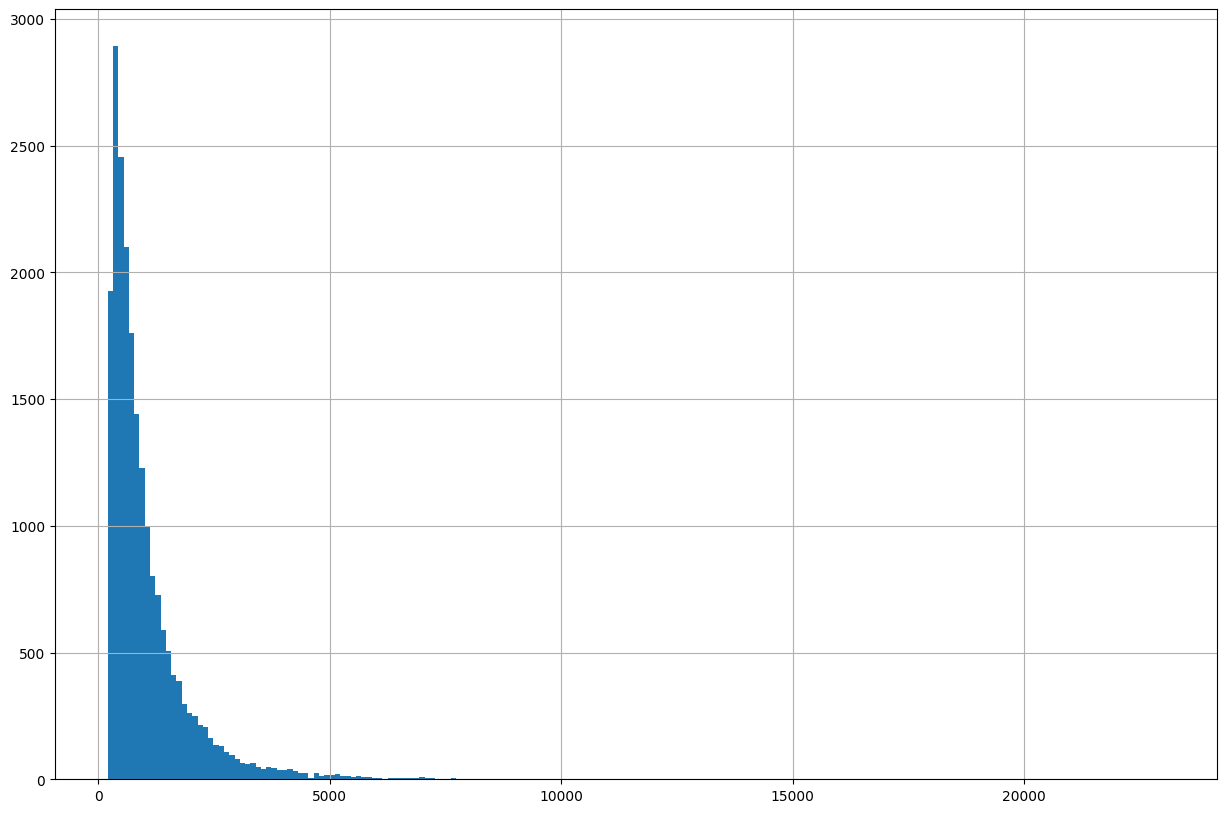

In [14]:
dream_df["text_dream"].str.len().hist( bins=200, figsize=(15, 10))

Some dreamers are real graphomans.

In [18]:
keywords_df["Interpretation"].str.len().sort_values(ascending=False).head(30)

71     35478
710    35263
782    32877
605    28500
417    25072
615    20182
758    18473
468    13211
469     3824
403     1140
283     1070
27       987
140      923
1        778
737      755
788      654
109      651
729      638
213      614
191      606
382      602
432      596
38       594
747      588
389      587
694      580
814      556
701      553
179      552
811      551
Name: Interpretation, dtype: int64

In [19]:
keywords_df

,Dream Symbol,Interpretation
0,Aardvark,To see an aardvark in your dream indicates tha...
1,Abandonment,To dream that you are abandoned suggests that ...
2,Abduction,To dream of being abducted indicates that you ...
3,Aborigine,To see an Aborigine in your dream represents b...
4,Abortion,To dream that you have an abortion suggests th...
...,...,...
898,Yoyo,To see or play with a yoyo in you dream signif...
899,Zebra,To see a zebra in your dream represents perfec...
900,Zip Line,To dream that you are zip lining implies that ...
901,Zombie,To see or dream that you are a zombie suggests...


In [20]:
keywords_df.iloc[10]

Dream Symbol                                         Academy Awards
Interpretation    To dream that you at the Academy Awards indica...
Name: 10, dtype: object

In [21]:
wat = keywords_df["Interpretation"].iloc[71]

In [ ]:


def slice_text(text):
    text = text.replace("\xa0", " ")

    text = re.sub(" +", " ", text).strip()


    p1 = r"(\. *)((\w+ )+)(To (see|dream|watch|make))"
    r1 = r'$1\n$2: $4'.replace(r'$', '\\')
    
    text = re.sub(p1, r1, text).strip()

    #text = re.sub(r"\s+", " ", text)

    text = text.split("\n")[1:]
    #print(text)
    text = [t.split(":") for t in text]
    text = [[t[0].strip(), t[1].strip()] for t in text]
    return text 


In [ ]:
def itrtr(row):
    sym = row["Dream Symbol"].replace("\n"," ")
    intp = row["Interpretation"]
    txt = f'. {sym} {intp}'
    #print(txt)
    a = slice_text(txt)
    #adf = pd.DataFrame(a, columns=['Dream Symbol',"Interpretation"])
    return a

In [25]:
keywords_df.iloc[59]

Dream Symbol                                            Bar Mitzvah
Interpretation    To dream that you are at a bar mitzvah or bat ...
Name: 59, dtype: object

In [26]:
itrtr(keywords_df.iloc[59])

. Bar Mitzvah To dream that you are at a bar mitzvah or bat mitzvah ceremony represents a transitional phase into adulthood. It indicates your social responsibilities, sense of morality, mental reasoning, and hopes.
['Bar Mitzvah : To dream that you are at a bar mitzvah or bat mitzvah ceremony represents a transitional phase into adulthood. It indicates your social responsibilities, sense of morality, mental reasoning, and hopes.']


[['Bar Mitzvah',
  'To dream that you are at a bar mitzvah or bat mitzvah ceremony represents a transitional phase into adulthood. It indicates your social responsibilities, sense of morality, mental reasoning, and hopes.']]

In [27]:
keywords_df['sliced'] = keywords_df.apply(itrtr, axis=1)
keywords_df

. Aardvark To see an aardvark in your dream indicates that you are being very secretive and cautious about your business.
['Aardvark : To see an aardvark in your dream indicates that you are being very secretive and cautious about your business.']
. Abandonment To dream that you are abandoned suggests that it is time to leave behind past feelings and characteristics that are hindering your growth. Let go of your old attitudes. A more direct and literal interpretation of this dream indicates you have a fear of being deserted, abandoned, or even betrayed. It may stem from a recent loss or a fear of losing a loved one. The fear of abandonment may manifest itself into your dream as part of the healing process and dealing with losing a loved one. It may also stem from unresolved feelings or problems from childhood. Alternatively, the dream indicates that you are feeling neglected or that your feelings are being overlooked. Perhaps the dream is a metaphor that you need to approach life with 

,Dream Symbol,Interpretation,sliced
0,Aardvark,To see an aardvark in your dream indicates tha...,"[[Aardvark, To see an aardvark in your dream i..."
1,Abandonment,To dream that you are abandoned suggests that ...,"[[Abandonment, To dream that you are abandoned..."
2,Abduction,To dream of being abducted indicates that you ...,"[[Abduction, To dream of being abducted indica..."
3,Aborigine,To see an Aborigine in your dream represents b...,"[[Aborigine, To see an Aborigine in your dream..."
4,Abortion,To dream that you have an abortion suggests th...,"[[Abortion, To dream that you have an abortion..."
...,...,...,...
898,Yoyo,To see or play with a yoyo in you dream signif...,"[[Yoyo, To see or play with a yoyo in you drea..."
899,Zebra,To see a zebra in your dream represents perfec...,"[[Zebra, To see a zebra in your dream represen..."
900,Zip Line,To dream that you are zip lining implies that ...,"[[Zip Line, To dream that you are zip lining i..."
901,Zombie,To see or dream that you are a zombie suggests...,"[[Zombie, To see or dream that you are a zombi..."


In [28]:
keywords_df['sliced'].values

array([list([['Aardvark', 'To see an aardvark in your dream indicates that you are being very secretive and cautious about your business.']]),
       list([['Abandonment', "To dream that you are abandoned suggests that it is time to leave behind past feelings and characteristics that are hindering your growth. Let go of your old attitudes. A more direct and literal interpretation of this dream indicates you have a fear of being deserted, abandoned, or even betrayed. It may stem from a recent loss or a fear of losing a loved one. The fear of abandonment may manifest itself into your dream as part of the healing process and dealing with losing a loved one. It may also stem from unresolved feelings or problems from childhood. Alternatively, the dream indicates that you are feeling neglected or that your feelings are being overlooked. Perhaps the dream is a metaphor that you need to approach life with 'reckless abandon' and live more freely."]]),
       list([['Abduction', 'To dream of bei

In [29]:
keywords_df['len'] = keywords_df['sliced'].apply(lambda x: len(x))
keywords_df

,Dream Symbol,Interpretation,sliced,len
0,Aardvark,To see an aardvark in your dream indicates tha...,"[[Aardvark, To see an aardvark in your dream i...",1
1,Abandonment,To dream that you are abandoned suggests that ...,"[[Abandonment, To dream that you are abandoned...",1
2,Abduction,To dream of being abducted indicates that you ...,"[[Abduction, To dream of being abducted indica...",1
3,Aborigine,To see an Aborigine in your dream represents b...,"[[Aborigine, To see an Aborigine in your dream...",1
4,Abortion,To dream that you have an abortion suggests th...,"[[Abortion, To dream that you have an abortion...",1
...,...,...,...,...
898,Yoyo,To see or play with a yoyo in you dream signif...,"[[Yoyo, To see or play with a yoyo in you drea...",1
899,Zebra,To see a zebra in your dream represents perfec...,"[[Zebra, To see a zebra in your dream represen...",1
900,Zip Line,To dream that you are zip lining implies that ...,"[[Zip Line, To dream that you are zip lining i...",1
901,Zombie,To see or dream that you are a zombie suggests...,"[[Zombie, To see or dream that you are a zombi...",1


In [30]:
glued = keywords_df[keywords_df['len'] >1 ]
glued

,Dream Symbol,Interpretation,sliced,len
71,Cab,To dream that you are hailing a cab suggests t...,"[[Cab, To dream that you are hailing a cab sug...",104
417,Lab Coat,To see or wear a lab coat in your dream symbol...,"[[Lab Coat, To see or wear a lab coat in your ...",76
468,Maintenance,To dream that something is in need of maintena...,"[[Maintenance, To dream that something is in n...",48
469,Marmalade,To make or eat marmalade in your dream indicat...,"[[Marmalade, To make or eat marmalade in your ...",11
605,Rabbit,"To see a rabbit in your dream signifies luck, ...","[[Rabbit, To see a rabbit in your dream signif...",87
615,Railroad Crossing,To see a railroad crossing gate in your dream ...,"[[Railroad Crossing, To see a railroad crossin...",65
710,Table,To see a table in your dream represents social...,"[[Table, To see a table in your dream represen...",87
758,-Turn,To make a u-turn in your dream indicates that ...,"[[UFO, To see an UFO in your dream signifies y...",50
782,Vacation,To dream that you are on vacation indicates th...,"[[Vacation, To dream that you are on vacation ...",95


In [31]:
expl = glued['sliced'].explode(1)
expl

0      [Cab, To dream that you are hailing a cab sugg...
1      [Cabana, To see or dream that you are in a cab...
2      [Cabaret, To watch a cabaret in your dream ind...
3      [Cabbage, To see or eat cabbage in your dream ...
4      [Cabin, To see or dream that you are in a wood...
                             ...                        
618    [Vow, To dream that you are making a vow repre...
619    [Voyage, To dream that you are making a voyage...
620    [Voyeurism, To dream that you are a voyeur sug...
621    [Vulture, To see a vulture in your dream symbo...
622    [Vulva, To see a vulva in your dream signifies...
Name: sliced, Length: 623, dtype: object

In [32]:
type(expl[0])

list

In [33]:
expl = pd.DataFrame([{'Dream Symbol':e[0], 'Interpretation': e[1]}  for e in expl])
expl

,Dream Symbol,Interpretation
0,Cab,To dream that you are hailing a cab suggests t...
1,Cabana,To see or dream that you are in a cabana signi...
2,Cabaret,To watch a cabaret in your dream indicates you...
3,Cabbage,To see or eat cabbage in your dream suggests t...
4,Cabin,To see or dream that you are in a wood cabin i...
...,...,...
618,Vow,To dream that you are making a vow represents ...
619,Voyage,To dream that you are making a voyage signifie...
620,Voyeurism,To dream that you are a voyeur suggests that y...
621,Vulture,To see a vulture in your dream symbolizes puri...


In [35]:
basic = keywords_df[keywords_df['len'] <=1 ][['Dream Symbol', 'Interpretation']]
basic

,Dream Symbol,Interpretation
0,Aardvark,To see an aardvark in your dream indicates tha...
1,Abandonment,To dream that you are abandoned suggests that ...
2,Abduction,To dream of being abducted indicates that you ...
3,Aborigine,To see an Aborigine in your dream represents b...
4,Abortion,To dream that you have an abortion suggests th...
...,...,...
898,Yoyo,To see or play with a yoyo in you dream signif...
899,Zebra,To see a zebra in your dream represents perfec...
900,Zip Line,To dream that you are zip lining implies that ...
901,Zombie,To see or dream that you are a zombie suggests...


In [36]:
fixed = pd.concat([basic, expl], ignore_index=True)
fixed

,Dream Symbol,Interpretation
0,Aardvark,To see an aardvark in your dream indicates tha...
1,Abandonment,To dream that you are abandoned suggests that ...
2,Abduction,To dream of being abducted indicates that you ...
3,Aborigine,To see an Aborigine in your dream represents b...
4,Abortion,To dream that you have an abortion suggests th...
...,...,...
1512,Vow,To dream that you are making a vow represents ...
1513,Voyage,To dream that you are making a voyage signifie...
1514,Voyeurism,To dream that you are a voyeur suggests that y...
1515,Vulture,To see a vulture in your dream symbolizes puri...


In [40]:
fixed["len"] = fixed["Interpretation"].str.len()

In [41]:
fixed.sort_values(by="len", ascending=False).head(30)

,Dream Symbol,Interpretation,len
958,Car,To dream that you are driving a car denotes yo...,4573
1349,Teeth,To dream that you have rotting or decaying tee...,2206
1352,Telephone,To see or hear a telephone in your dream signi...,1620
1124,Marriage,"To dream of a marriage signifies commitment, h...",1495
1007,Ladder,To dream that you are climbing up a ladder sug...,1449
1391,Underwater,To dream that you are underwater suggests that...,1444
1334,Tattoo,To dream that you have tattoos represent your ...,1396
1341,Teacher,To see your teacher (past or present) in your ...,1243
937,Candle,To see a burning candle in your dream signifie...,1181
1285,Table,To see a table in your dream represents social...,1155


In [48]:
fixed

,Dream Symbol,Interpretation,len
0,Aardvark,To see an aardvark in your dream indicates tha...,110
1,Abandonment,To dream that you are abandoned suggests that ...,778
2,Abduction,To dream of being abducted indicates that you ...,139
3,Aborigine,To see an Aborigine in your dream represents b...,330
4,Abortion,To dream that you have an abortion suggests th...,471
...,...,...,...
1512,Vow,To dream that you are making a vow represents ...,279
1513,Voyage,To dream that you are making a voyage signifie...,295
1514,Voyeurism,To dream that you are a voyeur suggests that y...,169
1515,Vulture,To see a vulture in your dream symbolizes puri...,534


In [42]:
fixed.sort_values(by="len", ascending=False).to_html("datasets/fixed_interpretations.html", index=False)

In [ ]:
fixed.sort_values(by="Dream Symbol").to_csv("datasets/fixed_interpretations.csv", index=False)

In [51]:
fixed["Dream Symbol"].nunique()

1216

In [63]:
q = """
select Interpretation, count(*) as cnt, string_agg(`Dream Symbol`, ',') as symbols
from fixed
group by Interpretation
order by cnt desc
"""

grouped = ps.sqldf(q)
grouped


,Interpretation,cnt,symbols
0,To see or sit on a recliner in your dream sugg...,3,"Recliner,Recliner,Recliner"
1,To see or play with an RC Car in your dream re...,3,"RC Car,RC Car,RC Car"
2,To see or eat tater tots in your dream implies...,3,"T,ater Tots,T ater Tots"
3,To see or eat taffy in your dream implies that...,3,"T,affy,T affy"
4,To see or eat lasagna in your dream symbolizes...,3,"Las,agna,Las agna"
...,...,...,...
1311,*Please see Headphones.,1,Earphones
1312,*Please See the Guard Dog.,1,Watchdog
1313,*Please See Fugitive .,1,Wanted
1314,*Please See Duck or See Dream Moods' Dream The...,1,Teal


In [68]:
len(set(["a","b"]))

2

In [97]:
grouped["sets"] = grouped.symbols.str.strip().str.split(",").apply(set)
grouped["len"] = grouped.sets.apply(len)
grouped = grouped.sort_values(by="len", ascending=False)
grouped

,Interpretation,cnt,symbols,len,fixed,symbol,Dream Symbol,sets
14,To dream that you are at a Laundromat represen...,3,"Lau,ndromat,Lau ndromat",3,Laundromat,Laundromat,Laundromat,"{Lau ndromat, Lau, ndromat}"
5,To see calla lilies in your dream symbolize ne...,3,"Ca,lla Lily,Ca lla Lily",3,Calla Lily,Calla Lily,Calla Lily,"{lla Lily, Ca lla Lily, Ca}"
6,To see a larva in your dream symbolizes a rebi...,3,"Lar,va,Lar va",3,Larva,Larva,Larva,"{Lar va, Lar, va}"
4,To see or eat lasagna in your dream symbolizes...,3,"Las,agna,Las agna",3,Lasagna,Lasagna,Lasagna,"{agna, Las agna, Las}"
3,To see or eat taffy in your dream implies that...,3,"T,affy,T affy",3,Taffy,Taffy,Taffy,"{affy, T affy, T}"
...,...,...,...,...,...,...,...,...
427,To see or apply Vaseline in your dream indicat...,1,Vaseline,1,Vaseline,Vaseline,Vaseline,{Vaseline}
429,"To see old, tattered rags in your dream indica...",1,Rags,1,Rags,Rags,Rags,{Rags}
493,To see an elephant in your dream indicates tha...,1,Elephant,1,Elephant,Elephant,Elephant,{Elephant}
462,To see blank white paper in your dream signifi...,1,Paper,1,Paper,Paper,Paper,{Paper}


In [98]:
azaz = grouped[grouped["len"] > 1]
azaz


,Interpretation,cnt,symbols,len,fixed,symbol,Dream Symbol,sets
14,To dream that you are at a Laundromat represen...,3,"Lau,ndromat,Lau ndromat",3,Laundromat,Laundromat,Laundromat,"{Lau ndromat, Lau, ndromat}"
5,To see calla lilies in your dream symbolize ne...,3,"Ca,lla Lily,Ca lla Lily",3,Calla Lily,Calla Lily,Calla Lily,"{lla Lily, Ca lla Lily, Ca}"
6,To see a larva in your dream symbolizes a rebi...,3,"Lar,va,Lar va",3,Larva,Larva,Larva,"{Lar va, Lar, va}"
4,To see or eat lasagna in your dream symbolizes...,3,"Las,agna,Las agna",3,Lasagna,Lasagna,Lasagna,"{agna, Las agna, Las}"
3,To see or eat taffy in your dream implies that...,3,"T,affy,T affy",3,Taffy,Taffy,Taffy,"{affy, T affy, T}"
2,To see or eat tater tots in your dream implies...,3,"T,ater Tots,T ater Tots",3,Tater Tots,Tater Tots,Tater Tots,"{ater Tots, T ater Tots, T}"
7,To see a Cadillac in your dream suggests that ...,3,"Ca,dillac,Ca dillac",3,Cadillac,Cadillac,Cadillac,"{Ca dillac, dillac, Ca}"
178,To dream of Easter Island represents self-expl...,2,"Easter,Island",2,EasterIsland,EasterIsland,EasterIsland,"{Easter, Island}"
170,To dream that you are a watchman suggests that...,2,"Wat,chman",2,Watchman,Watchman,Watchman,"{Wat, chman}"
59,To see or drink from a watering hole means tha...,2,"Wate,ring Hole",2,Watering Hole,Watering Hole,Watering Hole,"{Wate, ring Hole}"


In [99]:
def fixer(row):
    symbols = row["sets"]
    symbols = list(symbols)
    if len(symbols) == 1:
        return symbols[0]
    symbols.sort(key=len)
    symbols = symbols[:2]
    symbols.sort() 
    symbols = "".join(symbols)
    return symbols

grouped["Dream Symbol"] = grouped.apply(fixer, axis=1)
grouped = grouped[["Dream Symbol", "Interpretation"]]   
grouped

,Dream Symbol,Interpretation
14,Laundromat,To dream that you are at a Laundromat represen...
5,Calla Lily,To see calla lilies in your dream symbolize ne...
6,Larva,To see a larva in your dream symbolizes a rebi...
4,Lasagna,To see or eat lasagna in your dream symbolizes...
3,Taffy,To see or eat taffy in your dream implies that...
...,...,...
427,Vaseline,To see or apply Vaseline in your dream indicat...
429,Rags,"To see old, tattered rags in your dream indica..."
493,Elephant,To see an elephant in your dream indicates tha...
462,Paper,To see blank white paper in your dream signifi...


In [ ]:
q = """
select `Dream Symbol`, count(*) as cnt, string_agg(Interpretation, ',') as Interpretations
from grouped
group by `Dream Symbol`
order by cnt desc
"""

extract_keys = ps.sqldf(q)
extract_keys

,Dream Symbol,cnt,symbols
0,Voodoo,2,To dream that you are practicing voodoo sugges...
1,Vomiting,2,To dream that you are vomiting indicates that ...
2,Voldemort,2,To see Voldemort in your dream symbolizes an e...
3,Voiceless,2,To dream that you are voiceless represents a l...
4,Vizier,2,To see a vizier in your dream indicates that y...
...,...,...,...
1193,Abortion,1,To dream that you have an abortion suggests th...
1194,Aborigine,1,To see an Aborigine in your dream represents b...
1195,Abduction,1,To dream of being abducted indicates that you ...
1196,Abandonment,1,To dream that you are abandoned suggests that ...


In [105]:
q = """
SELECT `Dream Symbol`, 
  MAX(LENGTH(Interpretation)) AS max_length, 
  Interpretation
FROM grouped
GROUP BY `Dream Symbol`
HAVING LENGTH(Interpretation) = max_length
ORDER BY `Dream Symbol`
"""
result = ps.sqldf(q)
result

,Dream Symbol,max_length,Interpretation
0,Aardvark,110,To see an aardvark in your dream indicates tha...
1,Abandonment,778,To dream that you are abandoned suggests that ...
2,Abduction,139,To dream of being abducted indicates that you ...
3,Aborigine,330,To see an Aborigine in your dream represents b...
4,Abortion,471,To dream that you have an abortion suggests th...
...,...,...,...
1193,Zip Line,339,To dream that you are zip lining implies that ...
1194,Zombie,311,To see or dream that you are a zombie suggests...
1195,Zoomorphism,466,To dream that you are changing into the form o...
1196,com Tambourine,165,To see or play a tambourine in your dream symb...


In [106]:
result[["Dream Symbol", "Interpretation"]].to_csv("datasets/fixed_interpretations.csv", index=False)